In [59]:
import skgstat as skg
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.rk import Krige
from pykrige.compat import GridSearchCV
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [11]:
# parser function
def parser(fname):
    f = open(fname, "r")
    readings = []
    f.readline()
    f.readline()
    for line in f:
        temp = line.strip("\n").split()
        temp2 = [temp[0], int(temp[1]), float(temp[2]), float(temp[3]), float(temp[4]), float(temp[5]), float(temp[6])]
        readings.append(temp2)
    f.close()
    return readings

In [17]:
def extract(arr, ind):
    temp = []
    for i in arr:
        temp.append(i[ind])
        
    return temp

In [4]:
# populate data

# ID, Loop#, Timestamp, Freq, Lat, Long, RF reading
readings = parser("../data/data_testfile.txt")


In [41]:
lats = np.array(extract(readings,4))
long = np.array(extract(readings,5))
rf_freqs = np.array(extract(readings,6))

In [45]:
minlat = min(lats)
maxlat = max(lats)
minlong = min(long)
maxlong = max(long)
lat_mesh = np.arange(minlat,maxlat,abs(minlat-maxlat)/500)
long_mesh=np.arange(minlong,maxlong,abs(minlong-maxlong)/500)

In [46]:
long_mesh.shape

(500,)

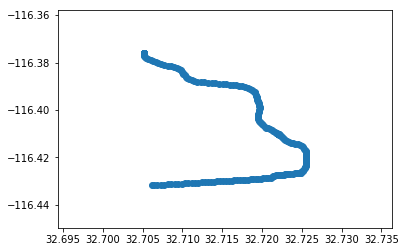

In [54]:
plt.scatter(lats,long)

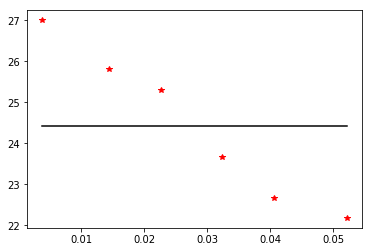

In [47]:
# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.

#example:
# OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], 
            #variogram_model='linear', verbose=False, enable_plotting=False)

OK = OrdinaryKriging(lats, long, rf_freqs, variogram_model='exponential',
                     verbose=False, enable_plotting=True)
z, ss = OK.execute('grid', lat_mesh, long_mesh)

In [48]:
# Writes the kriged grid to an ASCII grid file.
kt.write_asc_grid(lat_mesh, long_mesh, z, filename="output.asc")



AttributeError: 'QuadContourSet' object has no attribute 'set_size_inches'

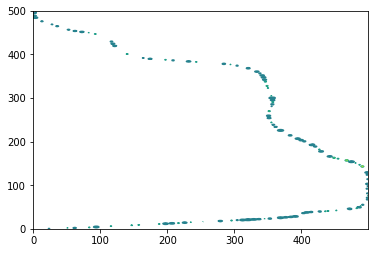

In [61]:
cplot = plt.contour(z)
cplot.set_size_inches(8,8)


In [55]:
z


masked_array(
  data=[[-107.94556835070247, -107.94556835116205, -107.9455683522406,
         ..., -107.94556835036109, -107.94556835036109,
         -107.94556835036109],
        [-107.94556835065937, -107.94556835105692, -107.94556835198334,
         ..., -107.94556835036109, -107.94556835036109,
         -107.94556835036109],
        [-107.94556835056126, -107.94556835082032, -107.94556835141222,
         ..., -107.94556835036109, -107.94556835036109,
         -107.94556835036109],
        ...,
        [-108.20284760244444, -108.17946614084677, -108.11005765619593,
         ..., -107.94556835036109, -107.94556835036109,
         -107.94556835036109],
        [-108.59486404527867, -108.44634135610416, -108.1929289826498,
         ..., -107.94556835036109, -107.94556835036109,
         -107.94556835036109],
        [-108.42295333884574, -108.43450021194776, -108.1987502329384,
         ..., -107.94556835036109, -107.94556835036109,
         -107.94556835036109]],
  mask=[[False, False

In [12]:
# 2D Kring param opt

param_dict = {"method": ["ordinary", "universal"],
              "variogram_model": ["linear", "power", "gaussian", "spherical"],
              # "nlags": [4, 6, 8],
              # "weight": [True, False]
              }

estimator = GridSearchCV(Krige(), param_dict, verbose=True)

# dummy data
X = np.random.randint(0, 400, size=(100, 2)).astype(float)
y = 5 * np.random.rand(100)

# run the gridsearch
estimator.fit(X=X, y=y)


if hasattr(estimator, 'best_score_'):
    print('best_score R² = {:.3f}'.format(estimator.best_score_))
    print('best_params = ', estimator.best_params_)

print('\nCV results::')
if hasattr(estimator, 'cv_results_'):
    for key in ['mean_test_score', 'mean_train_score',
                'param_method', 'param_variogram_model']:
        print(' - {} : {}'.format(key, estimator.cv_results_[key]))

# 3D Kring param opt

param_dict3d = {"method": ["ordinary3d", "universal3d"],
              "variogram_model": ["linear", "power", "gaussian", "spherical"],
              # "nlags": [4, 6, 8],
              # "weight": [True, False]
              }

estimator = GridSearchCV(Krige(), param_dict3d, verbose=True)

# dummy data
X3 = np.random.randint(0, 400, size=(100, 3)).astype(float)
y = 5 * np.random.rand(100)

# run the gridsearch
estimator.fit(X=X3, y=y)


if hasattr(estimator, 'best_score_'):
    print('best_score R² = {:.3f}'.format(estimator.best_score_))
    print('best_params = ', estimator.best_params_)

print('\nCV results::')
if hasattr(estimator, 'cv_results_'):
    for key in ['mean_test_score', 'mean_train_score',
                'param_method', 'param_variogram_model']:
        print(' - {} : {}'.format(key, estimator.cv_results_[key]))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will 

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.8s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBack

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.1s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
